In [1]:
pip install causalgraphicalmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from causalgraphicalmodels import StructuralCausalModel
from causalgraphicalmodels.csm import discrete_model, linear_model

from sklearn.linear_model import LinearRegression
import math
import itertools

# Continuous model

Generating the model

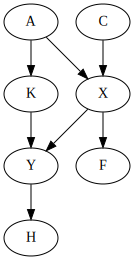

In [3]:
fd_cont = StructuralCausalModel({
    "C": lambda n_samples: np.random.uniform(low=-10, high=10,
                                             size=n_samples),
    "A": lambda n_samples: .8 * np.random.normal(size=n_samples),
    "K": lambda A, n_samples: A + .1 * np.random.normal(),
    "X": lambda C, A, n_samples: 0.7 * C - 2 * A + .2 * np.random.normal(),
    "F": lambda X, n_samples: 3 * X + .8 * np.random.normal(),
    "Y": lambda K, X, n_samples: 2 * K - X + .2 * np.random.normal(),
    "H": lambda Y, n_samples: .5 * Y + .1 * np.random.normal()
})

fd_cont.cgm.draw()

In [4]:
data_df = fd_cont.sample(n_samples=1000000)

In [5]:
data_df

,C,A,K,X,F,Y,H
0,-6.643064,-1.664985,-1.693771,-1.346165,-4.042839,-2.261340,-1.057240
1,-8.235087,0.142649,0.113864,-6.075849,-18.231892,6.083613,3.115237
2,-4.305760,0.730117,0.701331,-4.500256,-13.505110,5.682954,2.914907
3,4.078214,-0.597983,-0.626769,4.024725,12.069832,-5.498226,-2.675683
4,6.249589,-0.821560,-0.850346,5.991843,17.971184,-7.912498,-3.882819
...,...,...,...,...,...,...,...
999995,-6.199908,-0.234778,-0.263564,-3.896370,-11.693452,3.149278,1.648069
999996,-2.337460,-1.166725,-1.195510,0.671238,2.009370,-3.282222,-1.567681
999997,-0.189244,-0.161764,-0.190550,0.165068,0.490859,-0.766131,-0.309635
999998,-3.784740,-0.165543,-0.194328,-2.344223,-7.037013,1.735603,0.941232


Excercise 1:

Implement backdoor adjustment for arbitrary treatment, effect and conditioning set using Linear Regression.

Check if your implementation is working correctly.

In [6]:
all_sets = [
            ['C'],
            ['A'],
            ['K'],
            ['F'],
            ['H'],
            ['C', 'A'],
            ['C', 'K'],
            ['C', 'F'],
            ['C', 'H'],
            ['A', 'K'],
            ['A', 'F'],
            ['A', 'H'],
            ['K', 'F'],
            ['K', 'H'],
            ['F', 'H'],
            ['C', 'A', 'K'],
            ['C', 'A', 'F'],
            ['C', 'A', 'H'],
            ['C', 'K', 'F'],
            ['C', 'K', 'H'],
            ['C', 'F', 'H'],
            ['A', 'K', 'F'],
            ['A', 'K', 'H'],
            ['K', 'F', 'H'],
            ['C', 'A', 'K', 'F'],
            ['C', 'A', 'K', 'H'],
            ['C', 'K', 'F', 'H'],
            ['A', 'K', 'F', 'H'],
            ['C', 'A', 'K', 'F', 'H']
            ]

In [7]:
def my_backdoor_adjustment_regression(data=data_df, T='X', Y='Y', cond_set = ['A', 'K'], true_ate=None):
    # add your implementation
    # conditioning set can be empty, can contain 1 or more variables.
    # conditioning set never contains T or Y
    regressor = LinearRegression()
    # Regressing Y on [T, cond_set]
    regressor.fit(data[list(T) + cond_set].values, data[Y].values)  
    # Reporting coefficient of T
    print(f"Set: {list(T) + cond_set}, X has the coefficient: {regressor.coef_[0]}")
    coeff_X = regressor.coef_[0]
    # Check if the estimation is close to the actual causal effect
    if math.isclose(coeff_X, true_ate, rel_tol=1e-2) == True:
      return True
    else:
      return False   
        

In [8]:
my_backdoor_adjustment_regression(data_df, T='X', Y='Y', cond_set=[], true_ate = -1)

Set: ['X'], X has the coefficient: -1.1354728073587388


False

In [9]:
adj_sets = []
for var_set in all_sets:
  if my_backdoor_adjustment_regression(data_df, T='X', Y='Y', cond_set=var_set, true_ate = -1) == True:
    adj_sets.append(var_set)

Set: ['X', 'C'], X has the coefficient: -1.9999999999999998
Set: ['X', 'A'], X has the coefficient: -0.9999999999999987
Set: ['X', 'K'], X has the coefficient: -0.9999999999999987
Set: ['X', 'F'], X has the coefficient: 839226987836.7932
Set: ['X', 'H'], X has the coefficient: -2.1448614164566903e-16
Set: ['X', 'C', 'A'], X has the coefficient: -1.5464480874316928
Set: ['X', 'C', 'K'], X has the coefficient: -1.5464480874316928
Set: ['X', 'C', 'F'], X has the coefficient: -0.20000000000000012
Set: ['X', 'C', 'H'], X has the coefficient: -0.019084818565922607
Set: ['X', 'A', 'K'], X has the coefficient: -0.9999999999999991
Set: ['X', 'A', 'F'], X has the coefficient: -0.09999999999999998
Set: ['X', 'A', 'H'], X has the coefficient: -0.011421582064485384
Set: ['X', 'K', 'F'], X has the coefficient: -0.09999999999999998
Set: ['X', 'K', 'H'], X has the coefficient: -0.011193627523903757
Set: ['X', 'F', 'H'], X has the coefficient: 1.804503698469201e-16
Set: ['X', 'C', 'A', 'K'], X has the 

In [10]:
adj_sets

[['A'], ['K'], ['A', 'K']]

Valid adjustments sets:

In [11]:
fd_cont.cgm.get_all_backdoor_adjustment_sets(x='X', y='Y')

frozenset({frozenset({'A'}),
           frozenset({'K'}),
           frozenset({'A', 'K'}),
           frozenset({'A', 'C'}),
           frozenset({'C', 'K'}),
           frozenset({'A', 'C', 'K'})})

We notice that from the sets that adjustment sets (obtained by `get_all_backdoor_adjustment_sets`), those containing the random variable $C$ is missing fomr the sets contained in `adj_sets`.

This is due to the choice of linear regression as method of estimation. Choosing the right model would overcome this issue.



# Discrete model


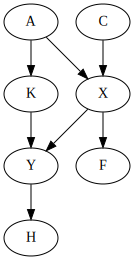

In [12]:
fd_disc = StructuralCausalModel({
    "C": lambda n_samples: np.random.binomial(n=1, p=0.7, size=n_samples),
    "A": lambda n_samples: np.random.binomial(n=1, p=0.2, size=n_samples),
    "K": lambda A, n_samples: A + .1 * np.random.normal(),
    "K": discrete_model(["A"], {
        (0, ): (0.9, 0.1),
        (1, ): (0.3, 0.7),
        }),
    "X": discrete_model(["C", "A"], {
        (0, 0): (0.1, 0.9), 
        (0, 1): (0.7, 0.3),
        (1, 0): (0.5, 0.5),
        (1, 1): (0.8, 0.2),
        }),  
    "F": discrete_model(["X"], {
        (0, ): (0.6, 0.4),
        (1, ): (0.1, 0.9),
        }),
    "Y": discrete_model(["K", "X"], {
        (0, 0): (0.9, 0.1), 
        (0, 1): (0.3, 0.7),
        (1, 0): (0.2, 0.5),
        (1, 1): (0.5, 0.5),
        }),
    "H": discrete_model(["Y"], {
        (0, ): (0.2, 0.4, 0.4),
        (1, ): (0.8, 0.1, 0.1),
        }),
})

fd_disc.cgm.draw()

In [13]:
data_disc = fd_disc.sample(n_samples = 1000000)
data_disc.head()

,C,A,K,X,F,Y,H
0,1,0,0.0,1.0,0.0,1.0,0.0
1,1,0,0.0,0.0,0.0,1.0,0.0
2,1,0,0.0,1.0,1.0,1.0,0.0
3,0,0,0.0,1.0,1.0,1.0,0.0
4,1,0,0.0,1.0,1.0,0.0,2.0


In [14]:
data_disc.describe()

,C,A,K,X,F,Y,H
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,0.699460,0.199989,0.219684,0.542386,0.671083,0.493154,0.756587
std,0.458493,0.399992,0.414033,0.498200,0.469820,0.499953,0.829978
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
75%,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


Identifying True causal effect:

In [15]:
set_variable_X = np.array([0]*500000 + [1]*500000)
ab_test_df = fd_disc.do('X').sample(
                    set_values={'X': set_variable_X}, 
                    n_samples=len(set_variable_X),
                  )
ab_test_df.head()

,C,A,X,K,F,Y,H
0,1,0,0,1.0,1.0,1.0,0.0
1,1,1,0,1.0,1.0,1.0,0.0
2,1,1,0,0.0,0.0,0.0,2.0
3,1,0,0,0.0,1.0,0.0,0.0
4,0,1,0,1.0,0.0,1.0,2.0


In [16]:
true_ate = ab_test_df[ab_test_df['X'] == 1]['Y'].mean() - ab_test_df[ab_test_df['X'] == 0]['Y'].mean()
true_ate

0.42057999999999995

Excercise 2:

1. Can we estimate causal effect for discrete model using regression? Try using the function you implemented above.
2. Test all possible adjustment sets. Are there any additional adjustments sets with correct result?

Valid backdoor adjustment sets

In [17]:
fd_disc.cgm.get_all_backdoor_adjustment_sets(x='X', y='Y')

frozenset({frozenset({'A'}),
           frozenset({'K'}),
           frozenset({'A', 'K'}),
           frozenset({'A', 'C'}),
           frozenset({'C', 'K'}),
           frozenset({'A', 'C', 'K'})})

In [18]:
adj_sets = []
for var_set in all_sets:
  if my_backdoor_adjustment_regression(data_disc, T='X', Y='Y', cond_set=var_set, true_ate = true_ate) == True:
    adj_sets.append(var_set)

Set: ['X', 'C'], X has the coefficient: 0.372417243927908
Set: ['X', 'A'], X has the coefficient: 0.440270558129932
Set: ['X', 'K'], X has the coefficient: 0.4244698690998433
Set: ['X', 'F'], X has the coefficient: 0.38288483564775594
Set: ['X', 'H'], X has the coefficient: 0.2837162005254933
Set: ['X', 'C', 'A'], X has the coefficient: 0.43461212628531287
Set: ['X', 'C', 'K'], X has the coefficient: 0.4175311560136074
Set: ['X', 'C', 'F'], X has the coefficient: 0.37179411132435763
Set: ['X', 'C', 'H'], X has the coefficient: 0.2757010563156437
Set: ['X', 'A', 'K'], X has the coefficient: 0.44012895069746694
Set: ['X', 'A', 'F'], X has the coefficient: 0.43956436382730507
Set: ['X', 'A', 'H'], X has the coefficient: 0.3286905545976576
Set: ['X', 'K', 'F'], X has the coefficient: 0.42368939193406996
Set: ['X', 'K', 'H'], X has the coefficient: 0.31879649903513263
Set: ['X', 'F', 'H'], X has the coefficient: 0.28331041428113785
Set: ['X', 'C', 'A', 'K'], X has the coefficient: 0.4345017

In [19]:
adj_sets

[['K'], ['C', 'K'], ['K', 'F'], ['C', 'K', 'F']]

Based on what we observe next, applying regression on descrete dataset captures a small subset of the adjust sets.

Excercise 3:

1. Implement backdoor adjustment for arbitrary treatment, effect and conditioning set using ATE formula.

Hint: you can use dummy variable to split your dataset according to all possible combinations of confounders.

Check if your implementation is working correctly.

2. Test all possible adjustment sets. Are there any additional adjustments sets with correct result?

In [20]:
def my_backdoor_adjustment_descrete(data=data_disc, T='X', Y='Y', cond_set = ['A', 'K'], true_ate=None):
    # add your implementation
    # conditioning set can be empty, can contain 1 or more variables.
    # conditioning set never contains T or Y
    if len(cond_set) == 0:
      ATE = data[data[T] == 1][Y].mean() - data[data[T] == 0][Y].mean()
    else:
      variable_values = []
      n = len(cond_set)
      ## list of lists that inner list (i) contain all values of ith variable in cond_set
      variable_values = [data[cond_set[i]].unique().astype(int).tolist() for i in range(n)]
      ## convert every value to character
      variable_values_char = [list(map(str, variable)) for variable in variable_values]
      ## construct all possible combination of values for variables of cond_set
      combinations = list(itertools.product(*variable_values_char ))
      ## now using the combinations we construct all possible queries within the data (dataframe)
      queries = []
      for i in range(len(combinations)):
        query_string = ''
        for j in range(n):
          query_string += f'{cond_set[j]} == {combinations[i][j]} and '
          if j == n-1:
            queries.append(query_string[:-5])
      ## example of an element in the queries list: 'A == 0 and K == 0'      
      ATE = 0
      ## Obtain possible values of X
      X_values = data[T].unique().astype(int).tolist()
      ATE_terms = []
      counter = 0
      for x in X_values:
        ATE_terms.append(0)
        for q in queries:
          ## Add current value of x to the query q (q is obtained from list of all possible queries, over which we are iterating)
          ## example of q: "A == 1 and K == 0"
          ## example of nq: "X == 0 and A == 1 and K == 0"
          nq = f'{T} == {x} and ' + q
          ## Probability of the event q occurring
          size = data.query(q).shape[0] / data.shape[0]
          ## Calucate expectation of Y based on the new query (nq) that adds current values of x to the query
          E_Y = data.query(nq)[Y].mean()
          ## Calculate E_Y conditioned on nq (query q + value of x)
          ## the condition has all values of the confounders and also the value of x
          ATE_terms[counter] += size * E_Y
        counter += 1;
      ## Since X (treatment) has 2 values, the following quantity would be just ATE[0] - ATE[1]
      ATE = ATE_terms[0] - ATE_terms[1]
    print(f"ATE for set {cond_set}: {ATE}")
    if math.isclose(ATE, true_ate, rel_tol=1e-2) == True:
      return True
    else:
      return False    

An example of the function above:


In [21]:
my_backdoor_adjustment_descrete(data=data_disc, T='X', Y='Y', cond_set = ['A', 'K'], true_ate=true_ate)

ATE for set ['A', 'K']: 0.4198110443986237


True

In [22]:
my_backdoor_adjustment_descrete(data=data_disc, T='X', Y='Y', cond_set=[], true_ate=true_ate)

ATE for set []: 0.3835328774669411


False

In [23]:
true_ate

0.42057999999999995

In [24]:
adj_sets = []
for var_set in all_sets:
  if my_backdoor_adjustment_descrete(data_disc, T='X', Y='Y', cond_set=var_set, true_ate = true_ate) == True:
    adj_sets.append(var_set)

ATE for set ['C']: 0.36344915715862264
ATE for set ['A']: 0.4198770973555338
ATE for set ['K']: 0.41977331047385574
ATE for set ['F']: 0.38258581065743824
ATE for set ['H']: 0.2601801512290151
ATE for set ['C', 'A']: 0.4194788891481185
ATE for set ['C', 'K']: 0.4197357876897502
ATE for set ['C', 'F']: 0.3628599814550745
ATE for set ['C', 'H']: 0.24536187245196694
ATE for set ['A', 'K']: 0.4198110443986237
ATE for set ['A', 'F']: 0.41855660601788536
ATE for set ['A', 'H']: 0.30667284239364434
ATE for set ['K', 'F']: 0.4188677419399475
ATE for set ['K', 'H']: 0.3281117801906501
ATE for set ['F', 'H']: 0.2593789022641266
ATE for set ['C', 'A', 'K']: 0.41942476726943034
ATE for set ['C', 'A', 'F']: 0.41866687706414196
ATE for set ['C', 'A', 'H']: 0.3064871836220375
ATE for set ['C', 'K', 'F']: 0.4190305946119196
ATE for set ['C', 'K', 'H']: 0.32806649669537286
ATE for set ['C', 'F', 'H']: 0.24465901965203418
ATE for set ['A', 'K', 'F']: 0.41863770865442496
ATE for set ['A', 'K', 'H']: 0.32

In [25]:
adj_sets

[['A'],
 ['K'],
 ['C', 'A'],
 ['C', 'K'],
 ['A', 'K'],
 ['A', 'F'],
 ['K', 'F'],
 ['C', 'A', 'K'],
 ['C', 'A', 'F'],
 ['C', 'K', 'F'],
 ['A', 'K', 'F'],
 ['C', 'A', 'K', 'F']]

The difference between the function I wrote and the built-in function `fd_disc.cgm.get_all_backdoor_adjustment_sets`, is that my function adds variable F to the combinations of adjust sets as well.

